<a href="https://colab.research.google.com/github/RonakMehta21/Advanced-Deep-Learning/blob/master/Assignment4/Simple_Multi_task_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-task Learning
This notebook demonstrates a simple and easy multi-task learning using Keras

In [1]:
#Import necessary libraries
import numpy as np
np.random.seed(0)
import pylab
%matplotlib inline
from keras.layers import Input, Dense, Layer
from keras.initializers import Constant
from keras.models import Model
from keras import backend as K

Define Custom Multi-loss layer

In [2]:
##Modified from: https://github.com/yaringal/multi-task-learning-example/blob/master/multi-task-learning-example.ipynb
class CustomMultiLossLayer(Layer):
    def __init__(self, nb_outputs=2, **kwargs):
        self.nb_outputs = nb_outputs
        self.is_placeholder = True
        super(CustomMultiLossLayer, self).__init__(**kwargs)
        
    def build(self, input_shape=None):
        # initialise log_vars
        self.log_vars = []
        for i in range(self.nb_outputs):
            self.log_vars += [self.add_weight(name='log_var' + str(i), shape=(1,),
                                              initializer=Constant(0.), trainable=True)]
        super(CustomMultiLossLayer, self).build(input_shape)

    def multi_loss(self, ys_true, ys_pred):
        assert len(ys_true) == self.nb_outputs and len(ys_pred) == self.nb_outputs
        loss = 0
        for y_true, y_pred, log_var in zip(ys_true, ys_pred, self.log_vars):
            precision = K.exp(-log_var[0])
            loss += K.sum(precision * (y_true - y_pred)**2. + log_var[0], -1)
        return K.mean(loss)

    def call(self, inputs):
        ys_true = inputs[:self.nb_outputs]
        ys_pred = inputs[self.nb_outputs:]
        loss = self.multi_loss(ys_true, ys_pred)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return K.concatenate(inputs, -1)

Train the model with synthetic data

In [3]:
N = 100
nb_epoch = 2000
batch_size = 20
nb_features = 1024
Q = 1
D1 = 1  # first output
D2 = 1  # second output

def gen_data(N):
    X = np.random.randn(N, Q)
    w1 = 2.
    b1 = 8.
    sigma1 = 1e1  # ground truth
    Y1 = X.dot(w1) + b1 + sigma1 * np.random.randn(N, D1)
    w2 = 3
    b2 = 3.
    sigma2 = 1e0  # ground truth
    Y2 = X.dot(w2) + b2 + sigma2 * np.random.randn(N, D2)
    return X, Y1, Y2

Plot the data

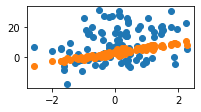

In [4]:
X, Y1, Y2 = gen_data(N)
pylab.figure(figsize=(3, 1.5))
pylab.scatter(X[:, 0], Y1[:, 0])
pylab.scatter(X[:, 0], Y2[:, 0])
pylab.show()

Define the model

In [5]:
def get_prediction_model():
    inp = Input(shape=(Q,), name='inp')
    x = Dense(nb_features, activation='relu')(inp)
    y1_pred = Dense(D1)(x)
    y2_pred = Dense(D2)(x)
    return Model(inp, [y1_pred, y2_pred])

def get_trainable_model(prediction_model):
    inp = Input(shape=(Q,), name='inp')
    y1_pred, y2_pred = prediction_model(inp)
    y1_true = Input(shape=(D1,), name='y1_true')
    y2_true = Input(shape=(D2,), name='y2_true')
    out = CustomMultiLossLayer(nb_outputs=2)([y1_true, y2_true, y1_pred, y2_pred])
    return Model([inp, y1_true, y2_true], out)

prediction_model = get_prediction_model()
trainable_model = get_trainable_model(prediction_model)
trainable_model.compile(optimizer='adam', loss=None)
assert len(trainable_model.layers[-1].trainable_weights) == 2  # two log_vars, one for each output
assert len(trainable_model.losses) == 1

In [6]:
prediction_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         2048        inp[0][0]                        
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1)            1025        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1)            1025        dense[0][0]                      
Total params: 4,098
Trainable params: 4,098
Non-trainable params: 0
___________________

In [7]:
trainable_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
y1_true (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
y2_true (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       [(None, 1), (None, 1 4098        inp[0][0]                        
_______________________________________________________________________________________

In [8]:
history = trainable_model.fit([X, Y1, Y2], epochs=nb_epoch, batch_size=batch_size)

Epoch 1/2000
5/5 [==============================] - 0s 2ms/step - loss: 213.1956
Epoch 2/2000
5/5 [==============================] - 0s 2ms/step - loss: 207.3696
Epoch 3/2000
5/5 [==============================] - 0s 2ms/step - loss: 201.6849
Epoch 4/2000
5/5 [==============================] - 0s 2ms/step - loss: 195.7738
Epoch 5/2000
5/5 [==============================] - 0s 2ms/step - loss: 189.7182
Epoch 6/2000
5/5 [==============================] - 0s 2ms/step - loss: 182.9431
Epoch 7/2000
5/5 [==============================] - 0s 2ms/step - loss: 175.7531
Epoch 8/2000
5/5 [==============================] - 0s 2ms/step - loss: 167.8038
Epoch 9/2000
5/5 [==============================] - 0s 2ms/step - loss: 160.2628
Epoch 10/2000
5/5 [==============================] - 0s 2ms/step - loss: 151.9627
Epoch 11/2000
5/5 [==============================] - 0s 2ms/step - loss: 143.4304
Epoch 12/2000
5/5 [==============================] - 0s 2ms/step - loss: 136.3148
Epoch 13/2000
5/5 [======

Plot the loss

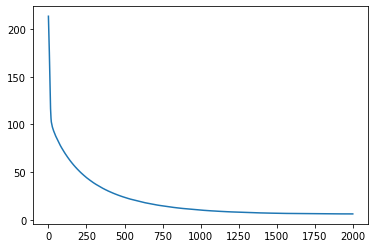

In [9]:
pylab.plot(history.history['loss'])